# Libraries

In [1]:
# Setup libraries 
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns


from tensorflow import keras
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import GlobalMaxPooling2D
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import RandomRotation
from tensorflow.keras.layers import RandomFlip


# Save Model Outputs

In [2]:
# Funtion to save output files and generate plots after model run

def save_results(model_name, my_model):

  '''
  save_results is a funtion to generate and save various files when a model has completed training

  Inputs

  model_name - the name of model files are being saved for
  me_model - the model object being documented

  Outputs

  - Model architecture from model.summary() 
  - history record of loss and accuracy saved as .csv file
  - Plot of loss for train and validation data .png image
  - Plot of accuracy for train and validation data saved as .png image
  - F1 score results saved as a .csv file
  - Confusion Matrix saved as a .png image

  This function returns nothing  
  '''
  # Display process start notice
  print(f'Post model activities for {model_name} \n')

  # Save model architecture summary as a .txt file
  with open(f'model_output/model_summary/{model_name}.txt', 'w') as f:
    model.summary(print_fn=lambda x: f.write(x + '\n'))

  ## Create loss and accuracy CSV file
  # Create dataframe with loss and accuracy results
  history_df = pd.DataFrame(my_model.history)

  # add Epoch number
  history_df['epoch'] = np.arange(1,history_df.shape[0]+1)

  # Save run history Metrics
  history_df.to_csv(f'model_output/history/{model_name}.csv')

  # Generate and save loss plot
  plt.plot(history_df['epoch'],history_df['loss'])
  plt.plot(history_df['epoch'],history_df['val_loss'])
  plt.title(f'{model_name} Loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'])
  plt.savefig(f'model_output/training_graphs/{model_name}_loss')
  plt.show()

  # Geneate and save accuracy plot
  plt.plot(history_df['epoch'],history_df['accuracy'])
  plt.plot(history_df['epoch'],history_df['val_accuracy'])
  plt.title(f'{model_name} Accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'])
  plt.savefig(f'model_output/training_graphs/{model_name}_accuracy.png')
  plt.show()
  


 

  ## Generate confusion matrix
  # Generate predictions

  X_test, y_test = test_generator.next()
  predict_probs = model.predict(X_test)

  # Convert encoded labels to text labels
  y_test_labels = np.argmax(y_test, axis=1)
  y_predict = np.argmax(predict_probs, axis=1)

  # Generate confusion_matrix
  conf_mat = confusion_matrix(y_test_labels, y_predict, normalize='pred')

  # Plot the confusion matrix
  class_names = ['Bride', 'Bouquet', 'Newlyweds', 'Reception Room', 'Wedding Party']
  plt.figure(figsize=(15, 10))
  sns.heatmap(
      conf_mat,
      annot=True,
      cbar=True,
      xticklabels=class_names,
      yticklabels=class_names,
      cmap='flare',
      linewidths=1)
  plt.title(f'{model_name} Confusion Matrix', size=25)
  plt.xlabel("Predicted Label", size=25)
  plt.ylabel("True Label", size=25)
  
  # Save the confusion matrix
  plt.savefig(f'model_output/training_graphs/{model_name}_confusion_matrix.png')
  plt.show()

  report = pd.DataFrame(classification_report(y_test_labels, y_predict, output_dict=True)).transpose()
  print(f'f1 - Scores \n{report["f1-score"][:5]}')
  report['f1-score'][:5].to_csv(f'model_output/test_results/{model_name}.csv')

  # Display completion message
  print('Evaluation files complete')
    
  return


# Image Generators 

In [3]:
# image attributes
height = 224
width = 224
channel = 3

# Create training image data generator.
train_datagen = ImageDataGenerator(rescale=1.0 / 255)

# Create validation image data generator. Only apply rescaling to our validation data.
validation_datagen = ImageDataGenerator(rescale=1.0 / 255)

# Apply the same rescaling factor as our other generators
test_datagen = ImageDataGenerator(rescale=1.0 / 255)

# Specify where the images should be loaded from as well as some additional attributes:
train_generator = train_datagen.flow_from_directory("data/data_07/train", target_size=(height, width), color_mode="rgb", batch_size=32, class_mode="categorical")
validation_generator = validation_datagen.flow_from_directory("data/data_07/val", target_size=(height, width), color_mode="rgb", batch_size=32, class_mode="categorical")
test_generator = test_datagen.flow_from_directory("data/data_07/test", target_size=(height, width), color_mode="rgb",  batch_size = 32,class_mode="categorical")


Found 2046 images belonging to 5 classes.
Found 254 images belonging to 5 classes.
Found 259 images belonging to 5 classes.


# ResNet50V2

In [4]:
# ResNet50V2 - Model Final

# Import Model
from tensorflow.keras.applications import ResNet50V2

# Create model object
model = ResNet50V2(weights="imagenet", include_top=False, input_shape=(height, width, channel))

# Freeze base model layers
model.trainable=False

# Add fine tuning layers
inputs=model.input
x = model(inputs)
x = RandomRotation(.2, seed=6489)(x)
x = RandomFlip(seed=6489)(x)
x = GlobalMaxPooling2D()(x)
x = Flatten()(x)
outputs = Dense(5, activation="softmax")(x)
model = keras.Model(inputs,outputs, name='23_03_ResNet50V2_Final')

# configure optimizer
tf.keras.optimizers.Adam(learning_rate=0.0001)

# Compile and run

In [5]:
# Compile Model
model.compile(optimizer="Adam", loss="categorical_crossentropy", metrics=["accuracy"])

#Show architechture 
model.summary()

Model: "23_03_ResNet50V2_Final"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 random_rotation (RandomRota  (None, 7, 7, 2048)       0         
 tion)                                                           
                                                                 
 random_flip (RandomFlip)    (None, 7, 7, 2048)        0         
                                                                 
 global_max_pooling2d (Globa  (None, 2048)             0         
 lMaxPooling2D)                                                  
                                                                 
 flatten (Flatten)           (None, 2048)   

Epoch 1/30


c:\Users\russk\anaconda3\envs\kibat_capstone\lib\site-packages\tensorflow\python\framework\indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/23_03_ResNet50V2_Final/random_rotation/loop_body/GatherV2/pfor/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/23_03_ResNet50V2_Final/random_rotation/loop_body/GatherV2/pfor/Reshape:0", shape=(None, 7, 7, 2048), dtype=float32), dense_shape=Tensor("gradient_tape/23_03_ResNet50V2_Final/random_rotation/loop_body/GatherV2/pfor/Cast:0", shape=(4,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


64/64 [==============================] - 122s 2s/step - loss: 1.9908 - accuracy: 0.7258 - val_loss: 1.2996 - val_accuracy: 0.8150
Epoch 2/30
64/64 [==============================] - 119s 2s/step - loss: 0.5601 - accuracy: 0.8900 - val_loss: 1.1428 - val_accuracy: 0.8465
Epoch 3/30
64/64 [==============================] - 117s 2s/step - loss: 0.2480 - accuracy: 0.9335 - val_loss: 1.0594 - val_accuracy: 0.8465
Epoch 4/30
64/64 [==============================] - 121s 2s/step - loss: 0.1192 - accuracy: 0.9638 - val_loss: 1.1968 - val_accuracy: 0.8465
Epoch 5/30
64/64 [==============================] - 118s 2s/step - loss: 0.0820 - accuracy: 0.9692 - val_loss: 1.0204 - val_accuracy: 0.8504
Epoch 6/30
64/64 [==============================] - 113s 2s/step - loss: 0.0621 - accuracy: 0.9780 - val_loss: 1.4564 - val_accuracy: 0.8425
Epoch 7/30
64/64 [==============================] - 112s 2s/step - loss: 0.0309 - accuracy: 0.9883 - val_loss: 1.0071 - val_accuracy: 0.8425
Epoch 8/30
64/64 [======

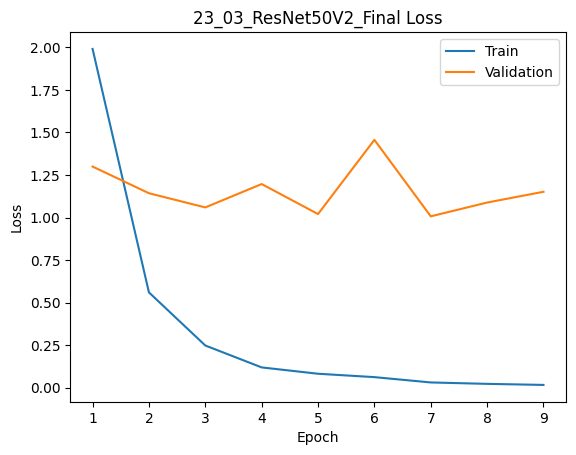

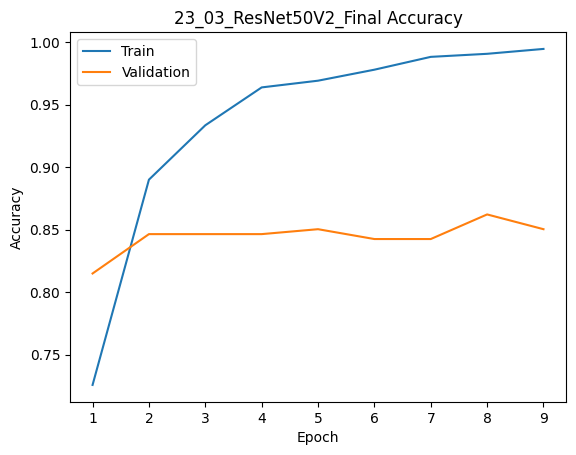

1/1 [==============================] - 2s 2s/step


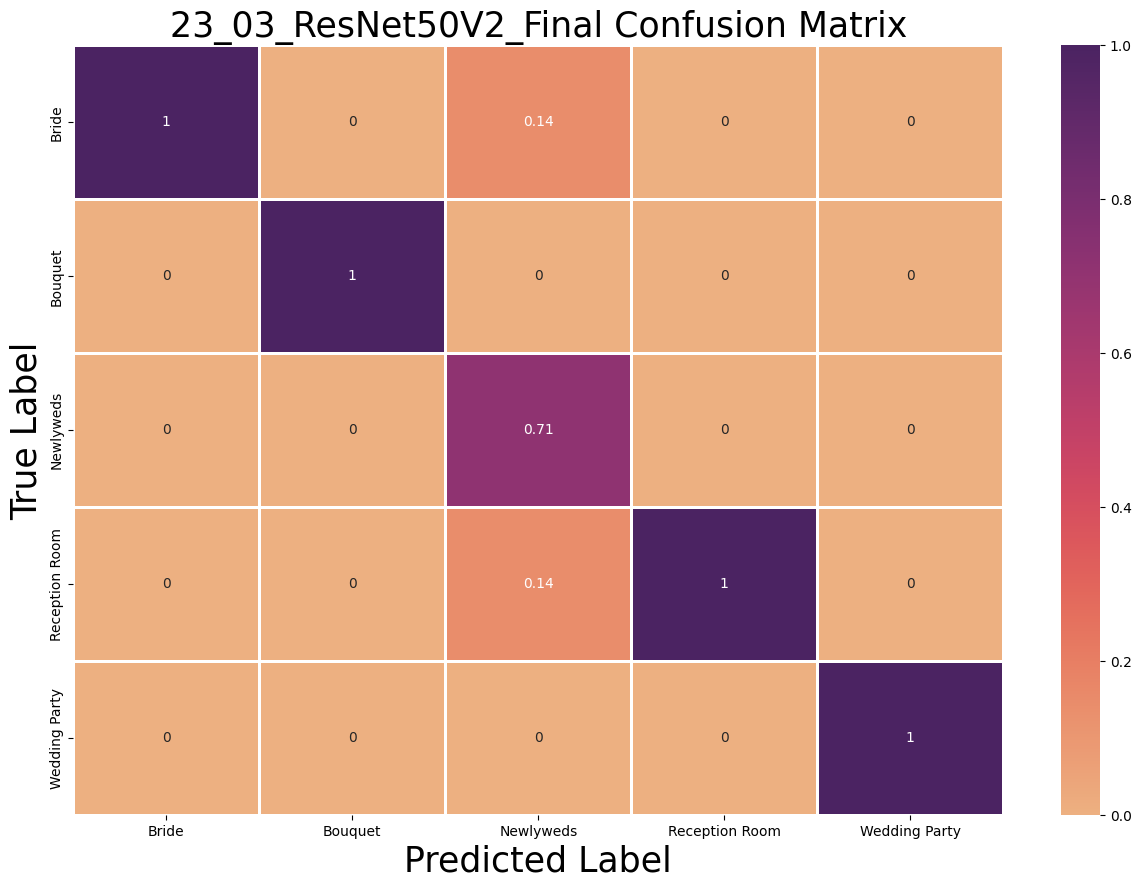

f1 - Scores 
0    0.933333
1    1.000000
2    0.833333
3    0.947368
4    1.000000
Name: f1-score, dtype: float64
Evaluation files complete


In [6]:
# Configure early stopping
early_stop = EarlyStopping(monitor="val_loss", min_delta=.001, patience=2, mode="min", verbose=1, restore_best_weights=True)

# Fit model
current_model = model.fit(train_generator, epochs=30, validation_data=validation_generator ,callbacks=[early_stop],)

# Save results 
save_results(model.name, current_model)
